## 1. Ségrégation temporelle jour

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
import re

def separate_integers_letters(string):
    integers = ''.join(re.findall(r'\d+', string))
    letters = ''.join(re.findall(r'[a-zA-Z]+', string))
    return integers, letters

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def add_labels(df):
  label_encoder = LabelEncoder()

  for index, row in df.iterrows():
    station_name_parts = row['station_name'].split('/')
    position_dynamique = station_name_parts[2]
    position_dynamique_parts = position_dynamique.split('_')
    _, position = separate_integers_letters(position_dynamique_parts[1])
    dynamique = position_dynamique_parts[2]

    df.loc[index, 'position'] = position
    df.loc[index, 'dynamique'] = dynamique

  df['position'] = label_encoder.fit_transform(df['position'])
  df['dynamique'] = label_encoder.fit_transform(df['dynamique'])

  df['label'] = df['position'].astype(str) + df['dynamique'].astype(str)
  df = df.drop(['position', 'dynamique'], axis=1)

  return df

In [27]:
from sklearn.metrics import accuracy_score

def custom_cross_validation(model, X_train, y_train, X_test, y_test):
    # Entraîner le modèle sur l'ensemble de données d'entraînement
    model.fit(X_train, y_train)

    # Prédire les étiquettes sur l'ensemble de test
    y_pred = model.predict(X_test)

    # Calculer la précision du modèle
    accuracy = accuracy_score(y_test, y_pred)

    return (accuracy, y_pred)

In [28]:
from sklearn.model_selection import RandomizedSearchCV

def rand_search_model(model, param_dist, X_train, y_train):
  # Use random search to find the best hyperparameters
  rand_search = RandomizedSearchCV(estimator = model,
                                   param_distributions = param_dist,
                                   n_iter = 5,
                                   cv = 5)

  # Fit the random search object to the data
  rand_search.fit(X_train, y_train)

  return rand_search

In [29]:
import numpy as np

# Définir l'espace de recherche des hyperparamètres
"""rf_param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'max_depth' : [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)] + [None],
    'min_samples_split' : [int(x) for x in np.linspace(start = 2, stop = 20, num = 19)],
    'min_samples_leaf' : [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)],
    'max_features' : ['sqrt', 'log2', None],
    'bootstrap' : [True, False]
}"""
rf_param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)],
    'max_depth' : [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)] + [None],
}

Dossier dossier_1 (train : 80.63% / test : 19.37%) :

Modèle par défaut : Précision sur l'ensemble de test : 0.32
Meilleur modèle : Précision sur l'ensemble de test : 0.31

Meilleurs hyperparamètres :
{'max_depth': 18, 'n_estimators': 200}



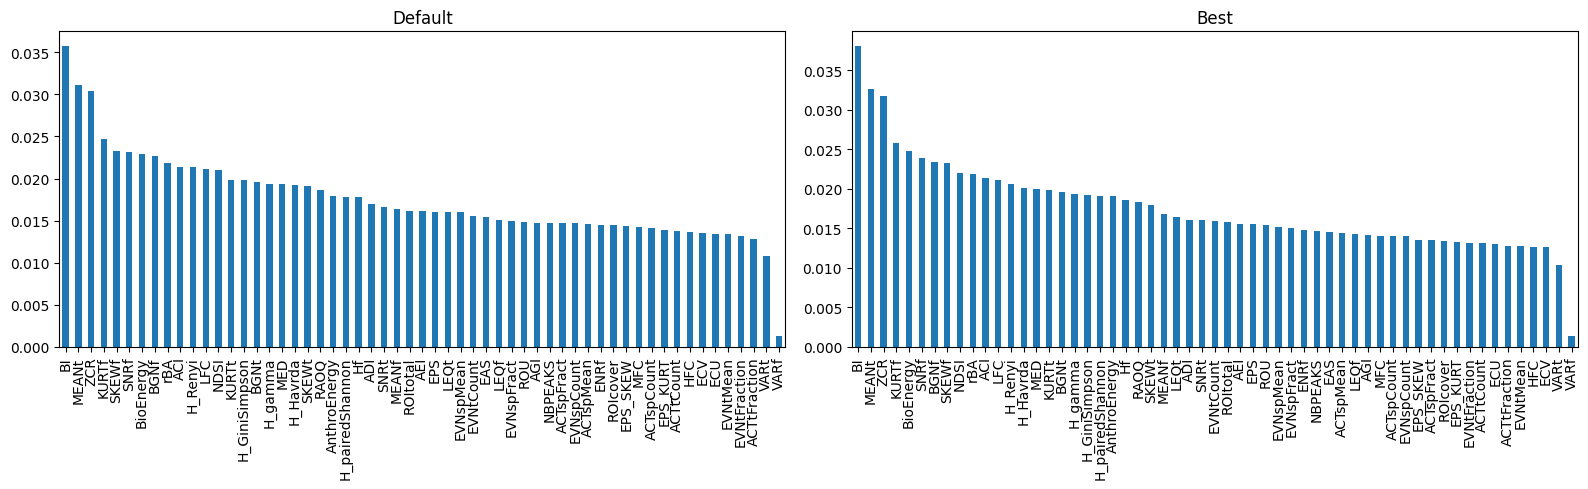

<ipython-input-30-65caa9699cda>:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


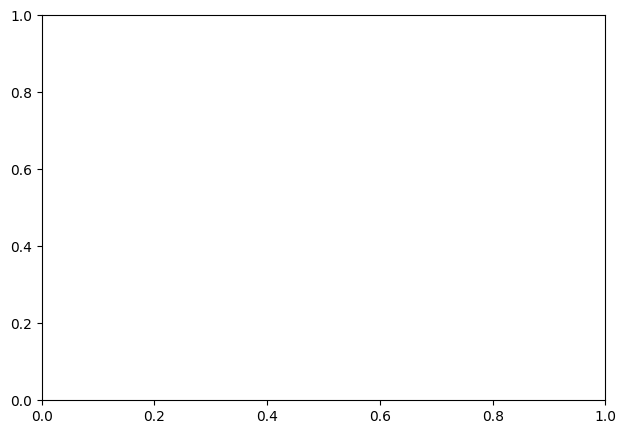

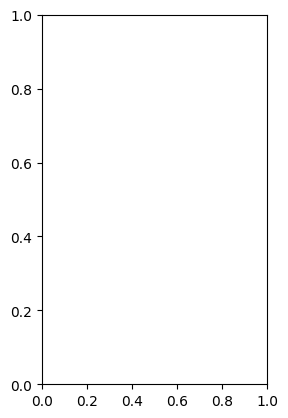

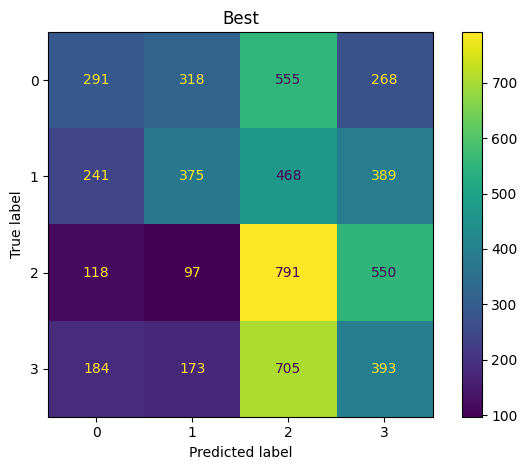



Dossier dossier_2 (train : 77.71% / test : 22.29%) :

Modèle par défaut : Précision sur l'ensemble de test : 0.33
Meilleur modèle : Précision sur l'ensemble de test : 0.22

Meilleurs hyperparamètres :
{'max_depth': 1, 'n_estimators': 400}



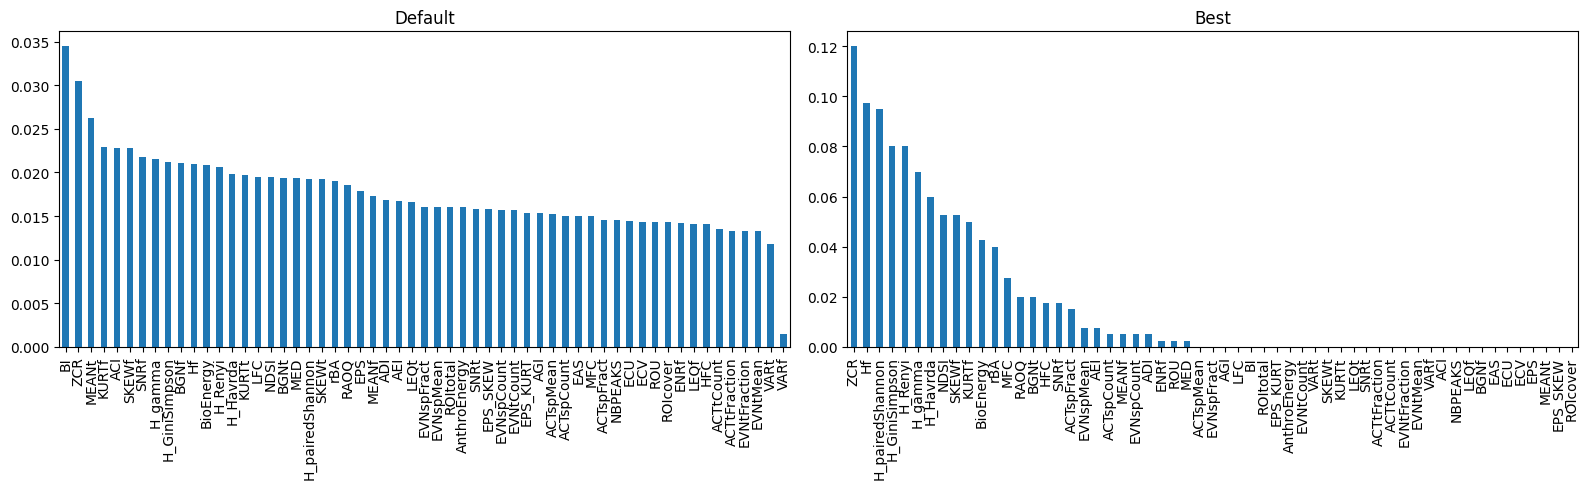

<ipython-input-30-65caa9699cda>:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


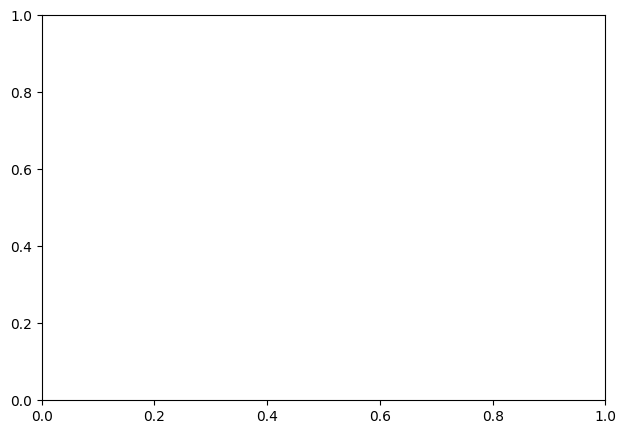

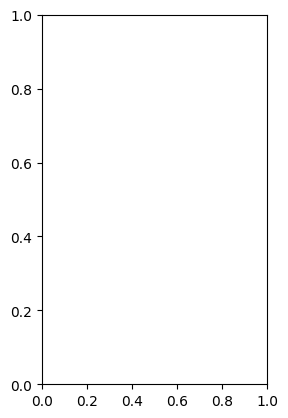

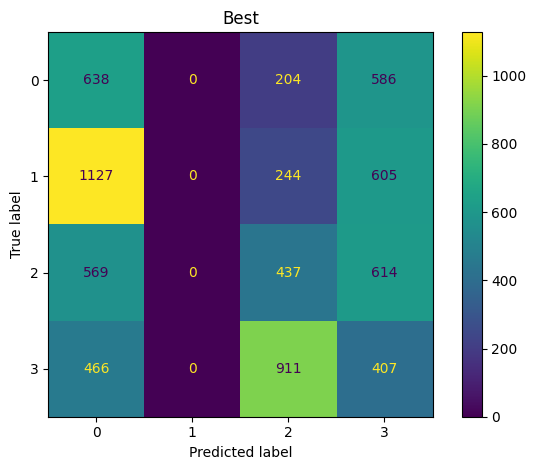



Dossier dossier_3 (train : 79.52% / test : 20.48%) :

Modèle par défaut : Précision sur l'ensemble de test : 0.39
Meilleur modèle : Précision sur l'ensemble de test : 0.39

Meilleurs hyperparamètres :
{'max_depth': 18, 'n_estimators': 500}



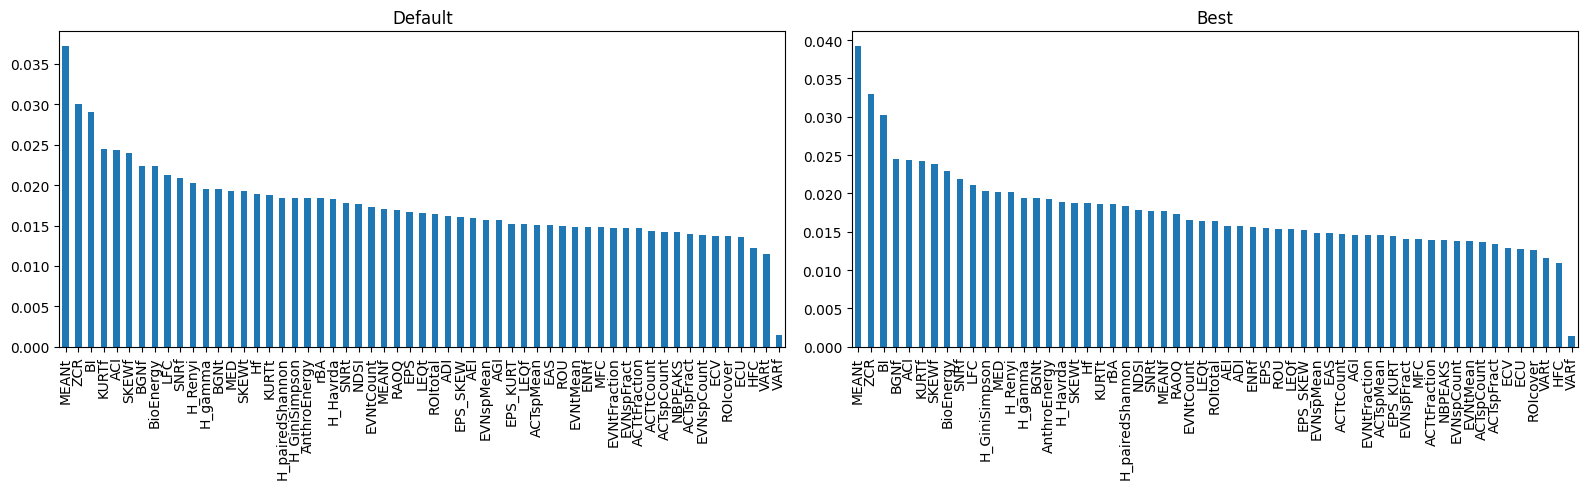

<ipython-input-30-65caa9699cda>:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


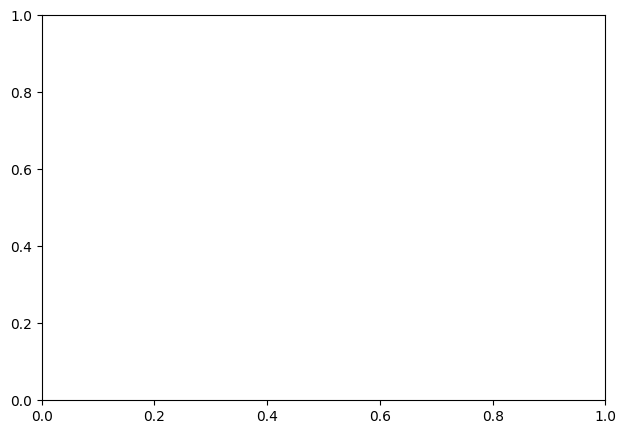

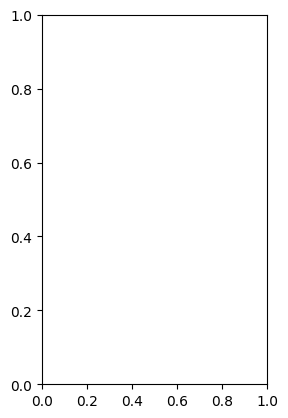

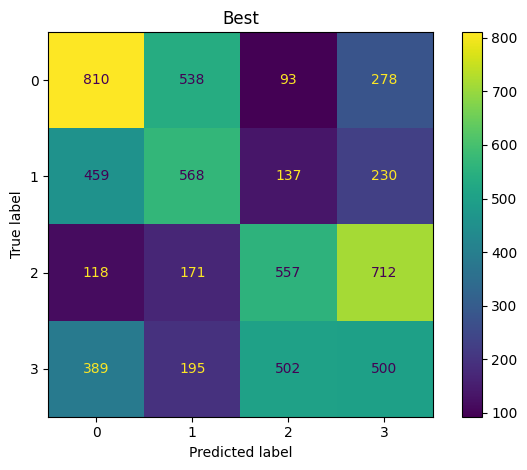



Dossier dossier_4 (train : 82.12% / test : 17.88%) :

Modèle par défaut : Précision sur l'ensemble de test : 0.4
Meilleur modèle : Précision sur l'ensemble de test : 0.4

Meilleurs hyperparamètres :
{'max_depth': None, 'n_estimators': 500}



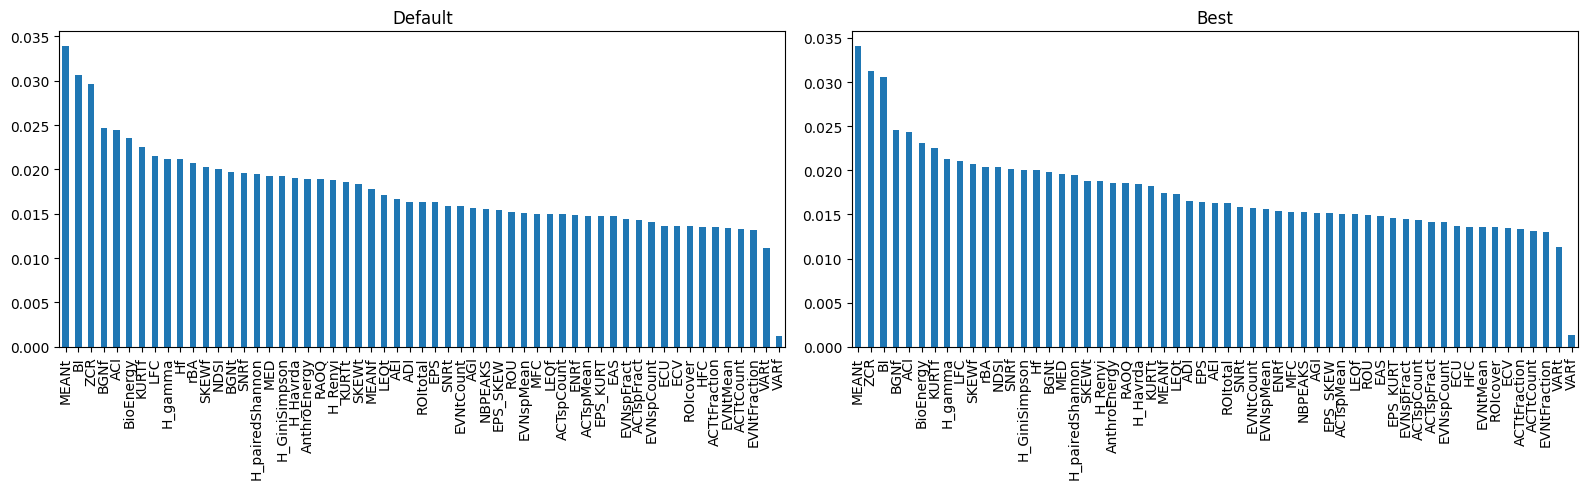

<ipython-input-30-65caa9699cda>:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


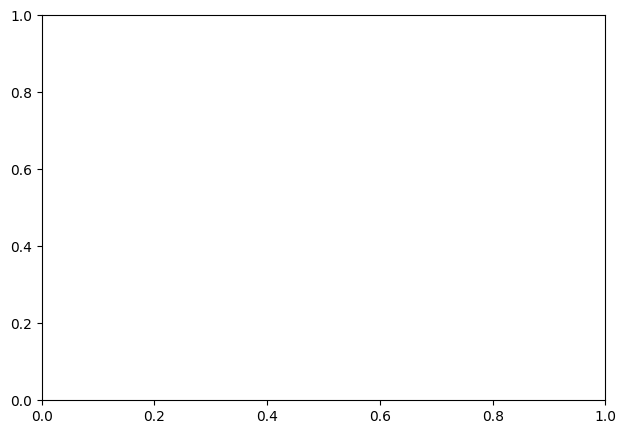

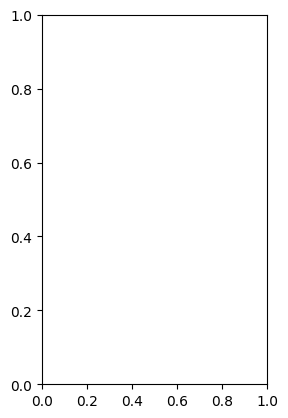

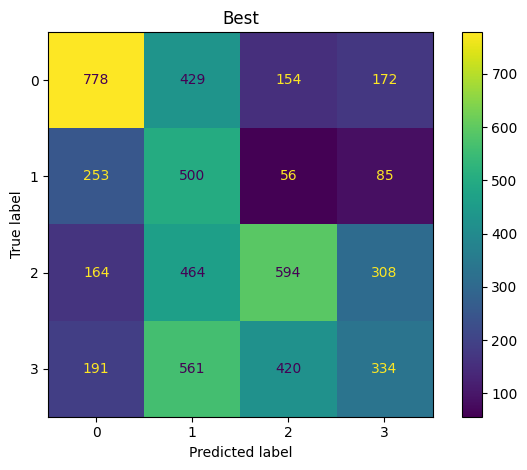



Dossier dossier_5 (train : 80.02% / test : 19.98%) :

Modèle par défaut : Précision sur l'ensemble de test : 0.37
Meilleur modèle : Précision sur l'ensemble de test : 0.37

Meilleurs hyperparamètres :
{'max_depth': 14, 'n_estimators': 300}



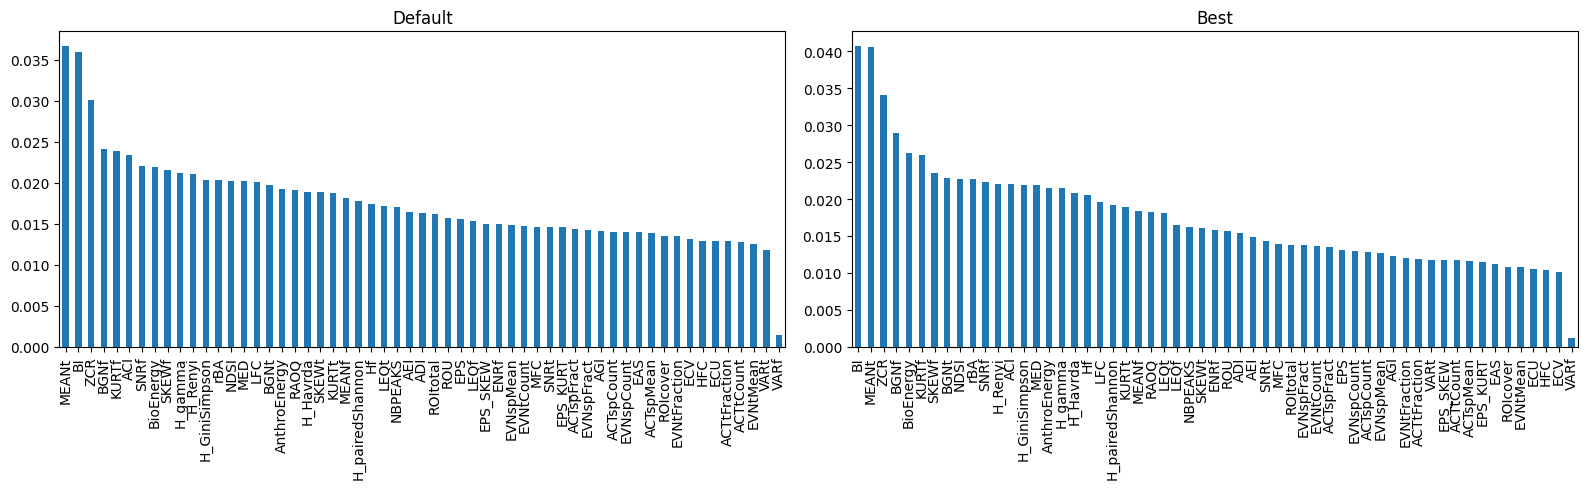

<ipython-input-30-65caa9699cda>:100: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


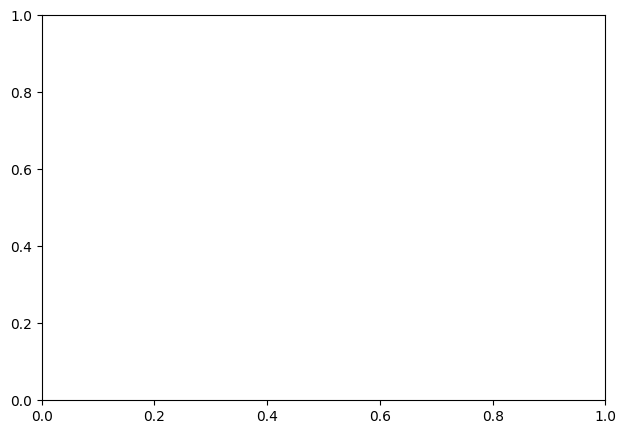

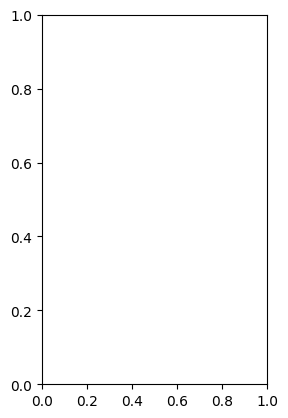

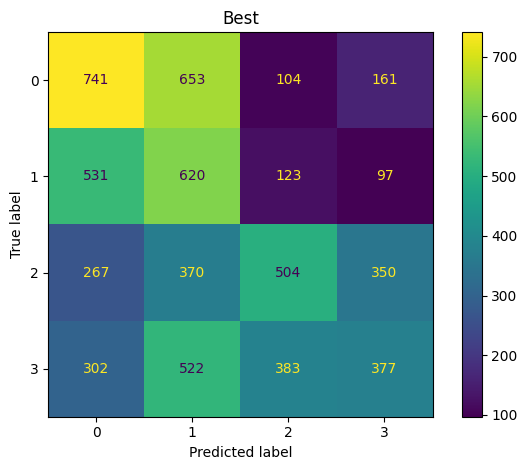



Modèle par défaut : Moyenne des précisions : 0.36
Meilleur modèle : Moyenne des précisions : 0.34


In [30]:
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pprint import pprint

# Chemin vers le répertoire contenant les dossiers de données sur Google Drive
data_directory = "/content/gdrive/MyDrive/ListenToTheWild/day_temporal"

# Liste des dossiers dans le répertoire
directories = sorted(os.listdir(data_directory))

rf_mean_acc = 0
best_rf_mean_acc = 0
# Boucle sur chaque dossier
for directory in directories:
  # Chemin vers le dossier contenant les fichiers de train/test
  directory_path = os.path.join(data_directory, directory)

  # Charger les données d'entraînement
  train_data = pd.read_csv(os.path.join(directory_path, "day_temporal_train.csv"))
  nb_rows_train = train_data.shape[0]
  # Ajouter les labels
  train_data_with_labels = add_labels(train_data)
  # Supprimer les colonnes "file_name" et "station_name"
  train_data_with_labels = train_data_with_labels.drop(['file_name', 'station_name'], axis=1)
  # Pour supprimer les NaN
  train_data_with_labels = train_data_with_labels.drop(['Ht', 'ACTtMean', 'TFSD'], axis=1)
  # Créer X et y
  X_train = train_data_with_labels.drop(columns=['label'])  # attributs
  y_train = train_data_with_labels['label']  # étiquettes

  # Charger les données de test
  test_data = pd.read_csv(os.path.join(directory_path, "day_temporal_test.csv"))
  nb_rows_test = test_data.shape[0]
  # Ajouter les labels
  test_data_with_labels = add_labels(test_data)
  # Supprimer les colonnes "file_name" et "station_name"
  test_data_with_labels = test_data_with_labels.drop(['file_name', 'station_name'], axis=1)
  # Pour supprimer les NaN
  test_data_with_labels = test_data_with_labels.drop(['Ht', 'ACTtMean', 'TFSD'], axis=1)
  # Créer X et y
  X_test = test_data_with_labels.drop(columns=['label'])  # attributs
  y_test = test_data_with_labels['label']  # étiquettes

  # Créer le modèle avec les paramètres par défaut
  rf_model = RandomForestClassifier()

  # Obtenir le meilleur modèle et les hyperparamètres associés
  rf_rand_search = rand_search_model(rf_model, rf_param_dist, X_train, y_train)
  best_rf_model = rf_rand_search.best_estimator_
  best_rf_params = rf_rand_search.best_params_

  # Effectuer les validations croisées personnalisées
  rf_accuracy, rf_y_pred = custom_cross_validation(rf_model, X_train, y_train, X_test, y_test)
  best_rf_accuracy, best_rf_y_pred = custom_cross_validation(best_rf_model, X_train, y_train, X_test, y_test)

  # Ajouter les valeurs pour le calcul des moyennes
  rf_mean_acc += rf_accuracy
  best_rf_mean_acc += best_rf_accuracy

  # Calculer les pourcentages des ensembles
  per_train_set = nb_rows_train / (nb_rows_train + nb_rows_test)
  per_test_set = nb_rows_test / (nb_rows_train + nb_rows_test)

  # Créer des séries contenant les importances des features des modèles et les noms des features à partir des données d'entraînement
  rf_feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
  best_rf_feature_importances = pd.Series(best_rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

  # Afficher les différents résultats
  print(f"Dossier {directory} (train : {round(per_train_set*100, 2)}% / test : {round(per_test_set*100, 2)}%) :")
  print()
  print(f"Modèle par défaut : Précision sur l'ensemble de test : {round(rf_accuracy, 2)}")
  print(f"Meilleur modèle : Précision sur l'ensemble de test : {round(best_rf_accuracy, 2)}")
  print()
  print("Meilleurs hyperparamètres :")
  pprint(best_rf_params)
  print()

  plt.figure(figsize=(16, 5))

  plt.subplot(1, 2, 1)
  rf_feature_importances.plot.bar();
  plt.title('Default')
  plt.subplot(1, 2, 2)
  best_rf_feature_importances.plot.bar();
  plt.title('Best')

  plt.tight_layout()
  plt.show()

  print()

  plt.figure(figsize=(16, 5))

  plt.subplot(1, 2, 1)
  ConfusionMatrixDisplay(confusion_matrix(y_test, rf_y_pred)).plot();
  plt.title('Default')
  plt.subplot(1, 2, 2)
  ConfusionMatrixDisplay(confusion_matrix(y_test, best_rf_y_pred)).plot();
  plt.title('Best')

  plt.tight_layout()
  plt.show()

  print()
  print("====================================================================================================================")
  print()

# Afficher les moyennes des précisions par modèle
nb_dir = len(directories)
print(f"Modèle par défaut : Moyenne des précisions : {round(rf_mean_acc/nb_dir, 2)}")
print(f"Meilleur modèle : Moyenne des précisions : {round(best_rf_mean_acc/nb_dir, 2)}")